In [1]:
import numpy as np
import pandas
import glob
import os
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
dataset=pandas.read_excel('Case.xlsx',sheet_name='initial')

data =dataset.values
X =data[:,1:18]
y =data[:,19]

validation_size = 0.2
seed =0
#划分训练集、测试集 7：3
X_train, X_test, y_train,y_test = train_test_split(X, y, test_size=validation_size, random_state=seed)

from imblearn.over_sampling import SMOTE, ADASYN
X_train, y_train = SMOTE().fit_resample(X_train, y_train)

In [3]:
# 数据归一化处理
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [4]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(3600, 17)
(3600,)
(488, 17)
(488,)


In [5]:
# 对数据处理
from keras.utils import np_utils

X_train = X_train.reshape((X_train.shape[0],17,1)) #-1：行数未知
#每时间步长的样本 时间步 特征
Y_train = np_utils.to_categorical(y_train)
X_test = X_test.reshape((X_test.shape[0],17,1))
Y_test = np_utils.to_categorical(y_test)

In [6]:
print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

(3600, 17, 1)
(3600, 2)
(488, 17, 1)
(488, 2)


### 模型

In [11]:
from keras import Sequential
from keras.layers import LSTM,Activation,Dense,Dropout,Input,Embedding,BatchNormalization,Add,concatenate,Flatten

model = Sequential()

model.add(LSTM(units=50,return_sequences=True,input_shape=(17,1)))
#unit 隐藏层尺寸
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))

# model.add(LSTM(units=50,return_sequences=True))
# model.add(Dropout(0.2))

model.add(LSTM(units=50))
model.add(Dropout(0.2))

# model.add(Dense(units=256))
# model.add(Dropout(0.2))
model.add(Dense(units=128))
model.add(Dropout(0.2))
model.add(Dense(units=64))
model.add(Dropout(0.2))
model.add(Dense(units=16))
model.add(Dropout(0.2))

model.add(Dense(units=1,activation="softmax"))
#units：设置该层节点数  activation：激活函数

In [12]:
# Implement Learning rate decay
from keras.callbacks import EarlyStopping,ReduceLROnPlateau,ModelCheckpoint,LearningRateScheduler

checkpoint = ModelCheckpoint("lstm.h5", #filepath
                             monitor="val_loss", #被监测的数据
                             mode="min", #auto/max/min
                             save_best_only = True, #被检测数据的最佳模型不被覆盖
                             verbose=1) #0/1-输出进度条记录

earlystop = EarlyStopping(monitor = 'val_loss', 
                          min_delta = 0,  #monitor的最小变化
                          patience = 5, #经过patience个epoch后停止训练
                          verbose = 1,  
                          restore_best_weights = True)#最佳监控值的epoch训练结果作为最终模型权值

reduce_lr = ReduceLROnPlateau(monitor = 'val_loss',
                              factor = 0.2, #每次减少学习率的因子，学习率将以lr=lr*factor的形式减少
                              patience = 3,
                              verbose = 1)
                              #min_delta = 0.00001)

callbacks = [earlystop, checkpoint, reduce_lr]

ModelCheckpoint: 在每个训练期之后保存模型

EarlyStopping: 当监测值不再改善，该回调函数将中止训练

ReduceLROnPlateau: 当评价指标不再提升时，减少学习率

In [13]:
model.compile(optimizer="adam", loss='categorical_crossentropy', metrics=['Precision'])

优化器=adam常见；loss损失函数=函数/函数代号

性能评估=Precision, Recall, AUC

In [14]:
history_fit = model.fit(x=X_train, 
                        y=y_train, 
                        batch_size=8, #一次训练所抓取的数据样本数量
                        epochs=30, 
                        verbose=1, 
                        validation_data=(X_test, y_test),
                        callbacks=callbacks)

Epoch 1/30
450/450 [==============================] - ETA: 0s - loss: 0.0000e+00 - precision: 0.5000
Epoch 1: val_loss improved from inf to 0.00000, saving model to lstm.h5
450/450 [==============================] - 12s 16ms/step - loss: 0.0000e+00 - precision: 0.5000 - val_loss: 0.0000e+00 - val_precision: 0.0840 - lr: 0.0010
Epoch 2/30
449/450 [============================>.] - ETA: 0s - loss: 0.0000e+00 - precision: 0.5006
Epoch 2: val_loss did not improve from 0.00000
450/450 [==============================] - 5s 12ms/step - loss: 0.0000e+00 - precision: 0.5000 - val_loss: 0.0000e+00 - val_precision: 0.0840 - lr: 0.0010
Epoch 3/30
447/450 [============================>.] - ETA: 0s - loss: 0.0000e+00 - precision: 0.4997
Epoch 3: val_loss did not improve from 0.00000
450/450 [==============================] - 5s 12ms/step - loss: 0.0000e+00 - precision: 0.5000 - val_loss: 0.0000e+00 - val_precision: 0.0840 - lr: 0.0010
Epoch 4/30
446/450 [============================>.] - ETA: 0s - l

batch_size 影响训练速度和模型优化，也影响每一epoch训练模型次数

若BATCH_SIZE=m(训练集样本数量);相当于直接抓取整个数据集，训练时间长，但梯度准确。只适用于小样本训练，但小样本训练一般会导致过拟合现象，因此不建议如此设置。

若BATCH_SIZE=1;梯度变化波动大，网络不容易收敛。

In [15]:
# 画曲线
def plot_performance(history=None,figure_directory=None,ylim_pad=[0,0]):
    xlabel="Epoch"
    legends=["Training","Validation"]
    
    plt.figure(figsize=(20,5))
    
    y1=history.history["precision"]
    y2=history.history["val_precision"]
    
    min_y=min(min(y1),min(y2))-ylim_pad[0]
    max_y=max(max(y1),max(y2))+ylim_pad[0]
    
    plt.subplot(121)
    
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title("Model Precision\n",fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("precision",fontsize=15)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    
    y1=history.history["loss"]
    y2=history.history["val_loss"]
    
    min_y=min(min(y1),min(y2))-ylim_pad[1]
    max_y=max(max(y1),max(y2))+ylim_pad[1]
    
    plt.subplot(122)
    
    plt.plot(y1)
    plt.plot(y2)
    
    plt.title("Model Loss:\n",fontsize=17)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel("Loss",fontsize=15)
    plt.ylim(min_y,max_y)
    plt.legend(legends,loc="upper left")
    plt.grid()
    plt.show()


<ipython-input-15-9881dfec5047>:40: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  plt.ylim(min_y,max_y)


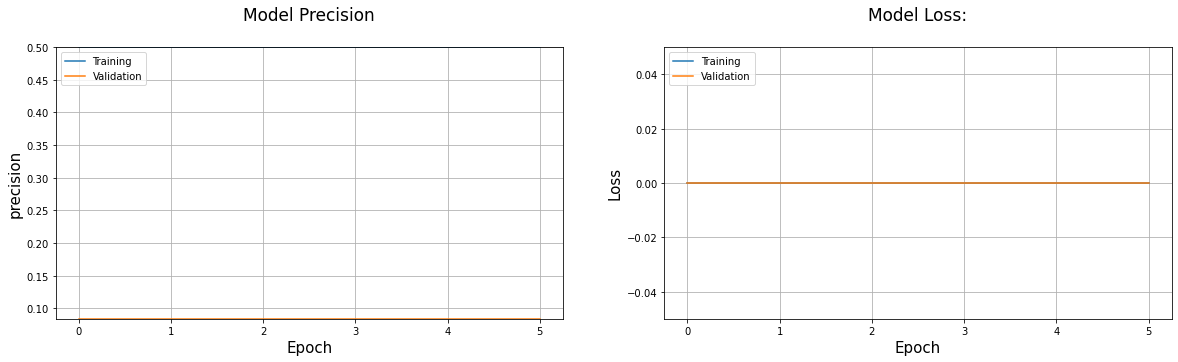

In [16]:
# 可视化
plot_performance(history=history_fit)

In [17]:
# 预测
predict_y = model.predict(X_test)
predict_y = np.argmax(predict_y,axis=1)

In [18]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

print(classification_report(y_test,predict_y))

              precision    recall  f1-score   support

         0.0       0.92      1.00      0.96       447
         1.0       0.00      0.00      0.00        41

    accuracy                           0.92       488
   macro avg       0.46      0.50      0.48       488
weighted avg       0.84      0.92      0.88       488



E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
E:\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [19]:
from sklearn.metrics import accuracy_score,f1_score,confusion_matrix,classification_report

cm = confusion_matrix(y_test,predict_y)
TP=cm[1][1]
TN=cm[0][0]
FP=cm[0][1]
FN=cm[1][0]

print(cm)
print("CSI: {:.3f}".format(TP/(TP+FP+FN)))
print('HSS: {:.3f}'.format((TP*TN-FN*FP)/((TP+FN)*(FN+TN)+(TP+FP)*(FP+TN))))

[[447   0]
 [ 41   0]]
CSI: 0.000
HSS: 0.000
